# Fast SQL Agent with LangGraph

This notebook demonstrates how to build a SQL-querying agent using LangGraph Runtime. The agent can analyze a SQLite database (Chinook) and answer questions by executing SQL queries.


## 1. Setup and Environment

First, load environment variables (API keys, etc.) from the `.env` file:


In [90]:
from dotenv import load_dotenv
import os
load_dotenv()

GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")
if not GOOGLE_API_KEY:
    raise EnvironmentError("GOOGLE_API_KEY not set in environment or .env file")



## 2. Import Dependencies

In [91]:
from langchain_community.utilities import SQLDatabase
from dataclasses import dataclass
from langchain_core.tools import tool
from langgraph.runtime import get_runtime
from langchain.agents import create_agent
from langchain_google_genai import ChatGoogleGenerativeAI


## 3. Database Connection

Connect to the Chinook SQLite database. This is a sample database containing data about a music store, including tables for artists, albums, tracks, customers, and invoices.


In [92]:
db = SQLDatabase.from_uri("sqlite:///data/Chinook.db")

### Explore Available Tables

Let's see what tables are available in the database:


In [93]:
db.get_usable_table_names()

['Album',
 'Artist',
 'Customer',
 'Employee',
 'Genre',
 'Invoice',
 'InvoiceLine',
 'MediaType',
 'Playlist',
 'PlaylistTrack',
 'Track']

## 4. Define Runtime Context

Create a `RuntimeContext` class to hold the database connection. This context will be accessible to tools via LangGraph's runtime.





In [94]:
@dataclass
class RuntimeContext:
    db:SQLDatabase

## 5. Create SQL Execution Tool

This tool allows the agent to execute SQL queries on the database.

### 🔑 Key Concept: Runtime Context
The tool uses `get_runtime(RuntimeContext)` to access the database connection from the LangGraph runtime context. This pattern allows tools to access shared resources without passing them directly.

⚠️ **Security Note**: In production environments, you should implement additional filters and validations on LLM-generated SQL commands to ensure they meet your security requirements.

In [95]:
@tool
def execute_sql(query:str)->str :
    """
    Execute a SQL query on the SQLite database and return the result as a string.
    """
    runtime = get_runtime(RuntimeContext)
    db=runtime.context.db

    # Prevent destructive operations
    forbidden_keywords = ['INSERT', 'UPDATE', 'DELETE', 'ALTER', 'DROP', 'CREATE', 'REPLACE', 'TRUNCATE']
    if any(keyword in query.upper() for keyword in forbidden_keywords):
        return "Error: Destructive operations are not allowed"

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"


## 6. Define System Prompt

The system prompt guides the agent's behavior and establishes ground rules for SQL query generation.



In [96]:
SYSTEM_PROMPT = """You are a careful SQLite analyst.

Rules:
- Think step-by-step and aim for efficiency.
- When comparing multiple tables, use UNION ALL queries to get all counts in one query.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

In [97]:

genai_llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash",
        api_key=GOOGLE_API_KEY,
        temperature=0.0,
)
tools = [execute_sql,
         ]

In [98]:
agent = create_agent(
    tools=tools,
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
    model=genai_llm
)

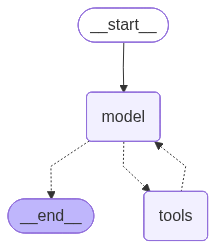

In [99]:
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [100]:

question = "Which table has the largest number of entries?"
for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()


================================ Human Message =================================

Which table has the largest number of entries?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (ee7468d9-fd2e-4dee-a9ec-b037df584338)
 Call ID: ee7468d9-fd2e-4dee-a9ec-b037df584338
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (0b913b22-749a-4c60-a811-b5837265dabe)
 Call ID: 0b913b22-749a-4c60-a811-b5837265dabe
  Args:
    query: SELECT 'Album' AS table_name, COUNT(*) AS num_entries FROM Album UNION ALL SELECT 'Artist', COUNT(*) FROM Artist UNION ALL SELECT 'Cu

In [101]:

question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (da1aadc4-b4e1-4f2a-85c8-0a3c6d9fe0fd)
 Call ID: da1aadc4-b4e1-4f2a-85c8-0a3c6d9fe0fd
  Args:
    query: SELECT T2.Name AS Genre, AVG(T1.Milliseconds) AS AverageTrackLength FROM tracks AS T1 INNER JOIN genres AS T2 ON T1.GenreId = T2.GenreId GROUP BY T2.Name ORDER BY AverageTrackLength DESC LIMIT 1;
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: tracks
[SQL: SELECT T2.Name AS Genre, AVG(T1.Milliseconds) AS AverageTrackLength FROM tracks AS T1 INNER JOIN genres AS T2 ON T1.GenreId = T2.GenreId GROUP BY T2.Name ORDER BY AverageTrackLength DESC LIMIT 1;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
================================== Ai Messa

In [102]:
question = "Please list all of the tables"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Please list all of the tables
================================== Ai Message ==================================
Tool Calls:
  execute_sql (51d4a4c1-eba0-48e3-aea6-d90480dd7ad5)
 Call ID: 51d4a4c1-eba0-48e3-aea6-d90480dd7ad5
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

The tables in the database are: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track.


In [103]:

question = "tell me about frank harris' recent purchase history."

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

tell me about frank harris' recent purchase history.
================================== Ai Message ==================================
Tool Calls:
  execute_sql (ced30856-20db-4741-939b-fa86ff806626)
 Call ID: ced30856-20db-4741-939b-fa86ff806626
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (4d997dd1-de52-475e-9d53-09d5738b475a)
 Call ID: 4d997dd1-de52-475e-9d53-09d5738b475a
  Args:
    query: PRAGMA table_info(Customer);
================================= Tool Message =================================
Name: execute_sql